# Timeseries Forecasting of Cryptocurrency Prices

In this exploration, I make an attempt to train recurrent neural networks to predict the price of cryptocurrencies such as bitcoin.

## Importing Libraries and Reading in the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('./data/BTC USD Historical Data.csv')
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jan 09, 2018","14,423.00","14,902.00","15,355.00","14,122.00",43.44K,-3.40
1,"Jan 08, 2018","14,930.00","16,216.00","16,279.00","13,760.00",64.95K,-7.82
2,"Jan 07, 2018","16,196.00","17,163.00","17,176.00","15,726.00",30.84K,-5.62
3,"Jan 06, 2018","17,161.00","16,911.00","17,252.00","16,251.00",29.61K,1.44
4,"Jan 05, 2018","16,917.00","15,159.00","17,101.00","14,769.00",54.63K,11.59


In [3]:
data.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2149,"Feb 04, 2012",5.87,5.87,5.87,5.87,0,-1.51
2150,"Feb 03, 2012",5.96,5.96,5.96,5.96,0,-2.30
2151,"Feb 02, 2012",6.10,6.10,6.10,6.10,0,0.33
2152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2153,NaN,"Highest:19,891.00",Lowest:0.00,"Difference:19,891.00",Average:995.73,"Change %:237,120.40",NaN


In [4]:
data.dropna(axis=0, inplace=True)
data = data.iloc[::-1]

In [5]:
from pandas import datetime
data['Date'] = data['Date'].apply(lambda date: pd.to_datetime(date))

In [6]:
import locale
from locale import *
locale.setlocale(locale.LC_NUMERIC, '')
data['Price'] = data['Price'].apply(lambda x: atof(x))

In [7]:
data['Open'] = data['Open'].apply(lambda x: atof(x))
data['High'] = data['High'].apply(lambda x: atof(x))
data['Low'] = data['Low'].apply(lambda x: atof(x))

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152 entries, 2151 to 0
Data columns (total 7 columns):
Date        2152 non-null datetime64[ns]
Price       2152 non-null float64
Open        2152 non-null float64
High        2152 non-null float64
Low         2152 non-null float64
Vol.        2152 non-null object
Change %    2152 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 134.5+ KB


## Visualizing prices for the whole dataset

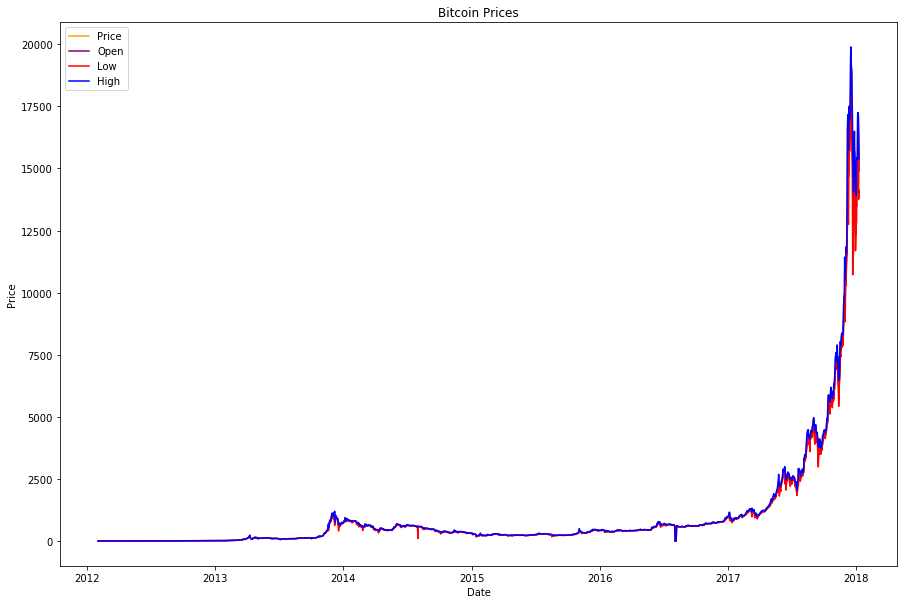

In [9]:
plt.plot(data['Date'], data['Price'], color = 'orange')
plt.plot(data['Date'], data['Open'], color='purple')
plt.plot(data['Date'], data['Low'], color='red')
plt.plot(data['Date'], data['High'], color='blue')
plt.title('Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.savefig('./plots/historical_prices.png')

## Using TensorFlow to Train RNNs

In [10]:
import tensorflow as tf

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [11]:
data = data.set_index('Date')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2152 entries, 2012-02-02 to 2018-01-09
Data columns (total 6 columns):
Price       2152 non-null float64
Open        2152 non-null float64
High        2152 non-null float64
Low         2152 non-null float64
Vol.        2152 non-null object
Change %    2152 non-null float64
dtypes: float64(5), object(1)
memory usage: 117.7+ KB


### Scaling the Data
In order to train a neural network on this data, it is a good idea to scale it first.

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
price_data_scaled = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

### Creating a Dataset with Features

In [16]:
def create_dataset(timeseries, n_inputs=30):
    
    features = []
    targets = []
    
    for i in range(len(timeseries) - n_inputs):
        
        start = i
        end = start + n_inputs
        
        x = timeseries[start:end]
        y = timeseries[end]
        
        features.append(x)
        targets.append(y)
    
    return np.array(features), np.array(targets)

In [17]:
X, y = create_dataset(price_data_scaled, n_inputs=14)

In [18]:
X.shape

(2138, 14, 1)

In [19]:
percent_training = 0.75
num_samples = X.shape[0]
num_train = int(percent_training * num_samples)

X_train, y_train = X[:num_train], y[:num_train]
X_test, y_test = X[num_train:], y[num_train:]

## Training the RNN Model

In [20]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

num_inputs = 14

model = Sequential()
model.add(LSTM(100, input_shape=(num_inputs, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)

Using TensorFlow backend.


In [21]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          batch_size=1, epochs=100, callbacks=[early_stopping])

Train on 1603 samples, validate on 535 samples
Epoch 1/100
1603/1603 [==============================] - 22s 14ms/step - loss: 1.7869e-05 - mean_absolute_error: 0.0030 - val_loss: 5.6528e-04 - val_mean_absolute_error: 0.0114
Epoch 2/100
1603/1603 [==============================] - 21s 13ms/step - loss: 6.9626e-06 - mean_absolute_error: 0.0019 - val_loss: 8.4611e-04 - val_mean_absolute_error: 0.0147
Epoch 3/100
1603/1603 [==============================] - 20s 12ms/step - loss: 5.5730e-06 - mean_absolute_error: 0.0017 - val_loss: 6.6565e-04 - val_mean_absolute_error: 0.0131
Epoch 4/100
1603/1603 [==============================] - 19s 12ms/step - loss: 4.6971e-06 - mean_absolute_error: 0.0015 - val_loss: 3.5282e-04 - val_mean_absolute_error: 0.0077
Epoch 5/100
1603/1603 [==============================] - 20s 12ms/step - loss: 4.2464e-06 - mean_absolute_error: 0.0014 - val_loss: 4.6739e-04 - val_mean_absolute_error: 0.0097
Epoch 6/100
1603/1603 [==============================] - 19s 12ms/st

In [22]:
model.save('./models/bitcoin_model.h5')

### Comparing Generated Predictions with Prices in Testing Set

In [23]:
pred = model.predict(X_test)

In [24]:
pred.shape

(535, 1)

In [25]:
results = scaler.inverse_transform(pred)

In [26]:
num_samples = pred.shape[0]
test_data_price = data.iloc[-num_samples:]['Price']

In [27]:
test_data_price_pred = pd.DataFrame({'Date': test_data_price.index, 
                                     'Price': test_data_price.values, 
                                     'Prediction': results[:, 0]})

In [28]:
test_data_price_pred

,Date,Prediction,Price
0,2016-07-10,620.903381,649.72
1,2016-07-11,622.435059,647.95
2,2016-07-12,620.695862,667.19
3,2016-07-13,639.120911,653.70
4,2016-07-14,627.852112,659.78
5,2016-07-15,634.169373,665.50
6,2016-07-16,639.760071,665.33
7,2016-07-17,639.938477,683.20
8,2016-07-18,657.002502,674.30
9,2016-07-19,649.368103,675.00


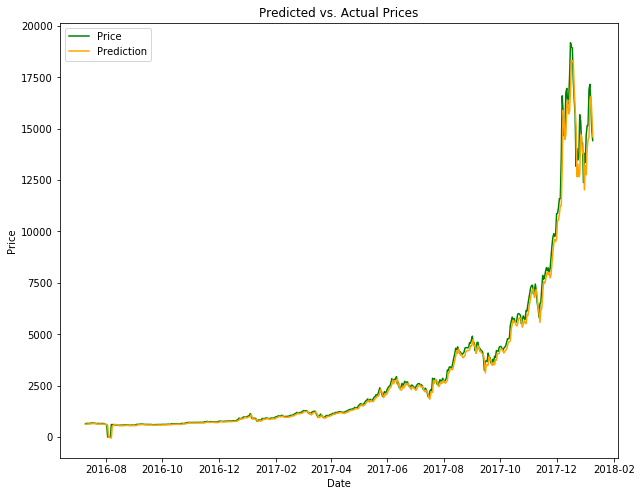

In [29]:
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Price'], color='green')
plt.plot(test_data_price_pred['Date'], test_data_price_pred['Prediction'], color='orange')
plt.legend()
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.savefig('./plots/predictions.png')